Train: 2023-01-01 00:00:00 → 2023-10-31 23:00:00
Test : 2023-11-01 00:00:00 → 2023-12-31 23:00:00


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        log_revenue   No. Observations:                 7285
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -3913.624
Date:                            Mon, 08 Dec 2025   AIC                           7857.247
Time:                                    22:23:57   BIC                           7960.547
Sample:                                         0   HQIC                          7892.784
                                           - 7285                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
temperature_2m (°C)      -0.0040      0.005     -0.845      0.398      -0.013       0.005
pr

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


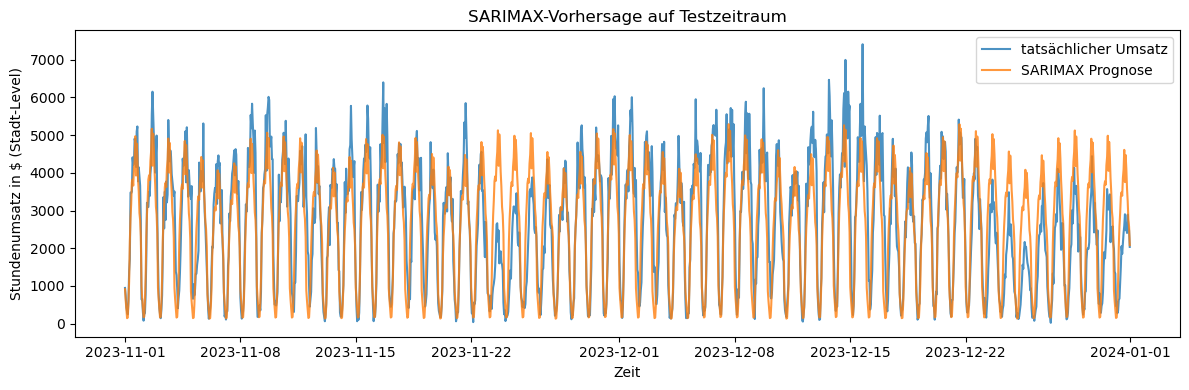

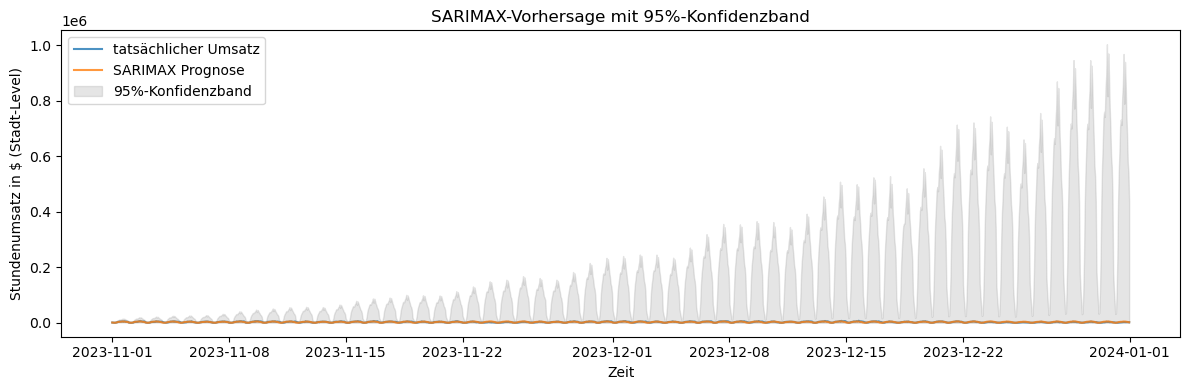

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --------------------------------------------------
# 1) Daten laden und vorbereiten
# --------------------------------------------------
df = pd.read_csv("../data/taxi_weather_merged-2.csv", parse_dates=["pickup_hour"])

# Zeitindex setzen
df["pickup_hour"] = pd.to_datetime(df["pickup_hour"])
df = df.set_index("pickup_hour").sort_index()

# Zielvariable: Umsatz pro Stunde in der Stadt
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])
df["log_revenue"] = np.log1p(df["revenue"])

# Exogene Variablen für SARIMAX
exog_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
]

exog = df[exog_cols]
y = df["log_revenue"]

# --------------------------------------------------
# 2) Zeitbasierten Train/Test-Split
# --------------------------------------------------
split_date = "2023-11-01"   # Grenze Training/Test

y_train = y[y.index < split_date]
y_test  = y[y.index >= split_date]

exog_train = exog[exog.index < split_date]
exog_test  = exog[exog.index >= split_date]

print("Train:", y_train.index.min(), "→", y_train.index.max())
print("Test :", y_test.index.min(),  "→", y_test.index.max())

# --------------------------------------------------
# 3) SARIMAX-Modell definieren und fitten
# --------------------------------------------------
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 24),  # tägliche (24h) Saison
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results = model.fit(disp=False)
print(results.summary())

# --------------------------------------------------
# 4) Prognose auf Test-Zeitraum
# --------------------------------------------------
n_train = len(y_train)
n_test  = len(y_test)

pred_log = results.get_prediction(
    start=n_train,                 # erste Stelle nach dem Train-Ende
    end=n_train + n_test - 1,      # letzte Test-Stelle
    exog=exog_test,
)

y_hat_test_log = pred_log.predicted_mean

# Zurück in Originalskala ($)
y_train_real = np.expm1(y_train)
y_test_real  = np.expm1(y_test)
y_hat_test   = np.expm1(y_hat_test_log)

# --------------------------------------------------
# 5) Gütemaße (MAE / RMSE) in $
# --------------------------------------------------
mae_test  = mean_absolute_error(y_test_real, y_hat_test)
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_hat_test))

print(f"\nTest MAE  : {mae_test:,.2f} $")
print(f"Test RMSE : {rmse_test:,.2f} $")

# --------------------------------------------------
# 6) Plot: tatsächlicher vs. vorhergesagter Umsatz
# --------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(y_test_real.index, y_test_real, label="tatsächlicher Umsatz", alpha=0.8)
plt.plot(y_test_real.index, y_hat_test, label="SARIMAX Prognose", alpha=0.8)
plt.xlabel("Zeit")
plt.ylabel("Stundenumsatz in $ (Stadt-Level)")
plt.title("SARIMAX-Vorhersage auf Testzeitraum")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7) Optional: 95%-Konfidenzband (in $)
# --------------------------------------------------
ci_log = pred_log.conf_int(alpha=0.05)     # im Log-Space
lower = np.expm1(ci_log["lower log_revenue"])
upper = np.expm1(ci_log["upper log_revenue"])

plt.figure(figsize=(12, 4))
plt.plot(y_test_real.index, y_test_real, label="tatsächlicher Umsatz", alpha=0.8)
plt.plot(y_test_real.index, y_hat_test, label="SARIMAX Prognose", alpha=0.8)
plt.fill_between(y_test_real.index, lower, upper, color="gray", alpha=0.2,
                 label="95%-Konfidenzband")
plt.xlabel("Zeit")
plt.ylabel("Stundenumsatz in $ (Stadt-Level)")
plt.title("SARIMAX-Vorhersage mit 95%-Konfidenzband")
plt.legend()
plt.tight_layout()
plt.show()